# Energy Time Series Forecasting

## Introduction

Prédiction de la consommation d’énergie du business groupe dans Alesund à partir des données historiques.

## Import des bibliothèques

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

## Chargement des données 

In [ ]:
df_business_consumption=pd.read_csv('business_group_data.csv')  # Load your dataset

In [ ]:
df_business_consumption['Date'] = pd.to_datetime(
    df_business_consumption['Date'])    # Convert 'Date' column to datetime

In [ ]:
# Création de la nouvelle colonne
df_business_consumption["Consommation"] = df_business_consumption["VOLUME_KWH"] / df_business_consumption["METERINGPOINT_COUNT"]  # Calcul de la consommation moyenne par point de mesure 

# Suppression des deux colonnes d'origine
df_business_consumption.drop(columns=["VOLUME_KWH", "METERINGPOINT_COUNT"], inplace=True)  # Drop the original columns


## Feature engineering

In [ ]:

# Extraire les composants de date
df_business_consumption['hour'] = df_business_consumption['Date'].dt.hour   #extract hour from Date between 0 and 23
df_business_consumption['month'] = df_business_consumption['Date'].dt.month   # extract month from Date between 1 and 12
df_business_consumption['weekday'] = df_business_consumption['Date'].dt.weekday  # extract weekday 0 = lundi, 6 = dimanche
df_business_consumption['dayofyear'] = df_business_consumption['Date'].dt.dayofyear # extract day of year from Date between 1 and 365

# Vérification
df_business_consumption.head()


,Date,wind_speed,t2m_C,surface_pressure,Consommation,hour,month,weekday,dayofyear
0,2021-01-01 00:00:00,2.798005,1.68923,98874.560,8.082154,0,1,4,1
1,2021-01-01 01:00:00,2.630726,1.32168,98905.060,8.021209,1,1,4,1
2,2021-01-01 02:00:00,2.387332,1.01553,98930.625,8.132821,2,1,4,1
3,2021-01-01 03:00:00,1.984651,0.77847,98928.000,8.151846,3,1,4,1
4,2021-01-01 04:00:00,1.515596,0.66543,98949.560,8.389451,4,1,4,1


In [ ]:
df_business_consumption.drop(columns=["wind_speed", "surface_pressure"], inplace=True) # Drop the columns that are not needed for the model based on the previous analysis

##  Prétraitement des données

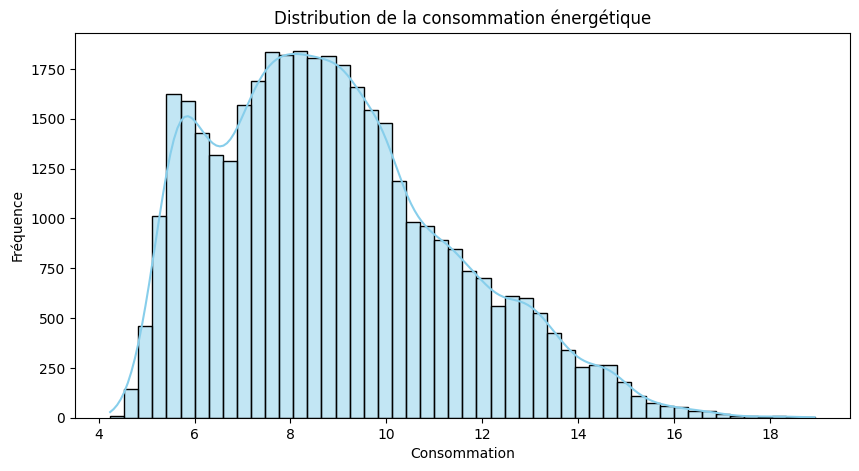

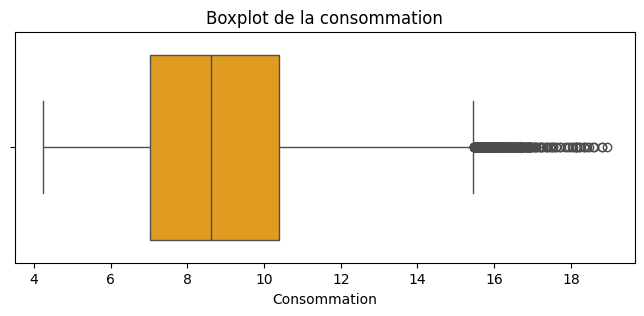

In [7]:

# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["Consommation"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la consommation énergétique")
plt.xlabel("Consommation")
plt.ylabel("Fréquence")
plt.show()

# Boxplot (pour voir les outliers)
plt.figure(figsize=(8, 3))
sns.boxplot(x=df_business_consumption["Consommation"], color="orange")
plt.title("Boxplot de la consommation")
plt.show()


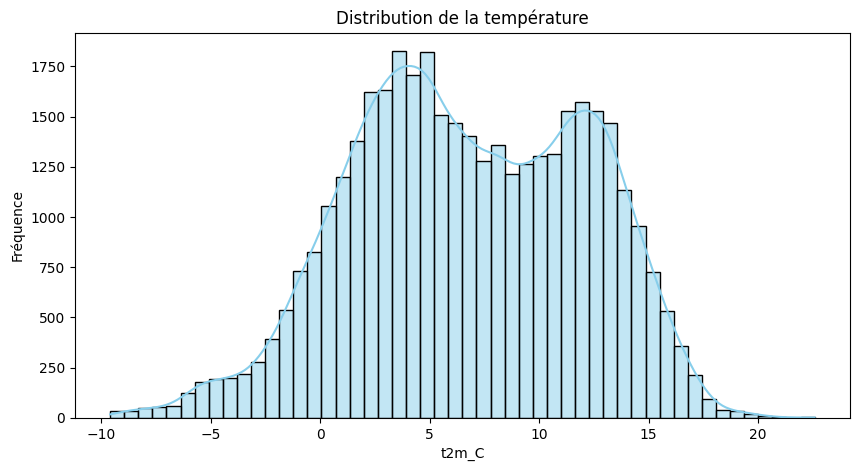

In [8]:
# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["t2m_C"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la température")
plt.xlabel("t2m_C")
plt.ylabel("Fréquence")
plt.show()

MinMaxScaler  il est plus adapté aux données asymétriques .

In [ ]:
from sklearn.preprocessing import MinMaxScaler  # MinMaxScaler is more suitable for asymmetric and bounded data.
df_normalise=df_business_consumption.copy()     # Create a copy of the DataFrame to avoid modifying the original data
# Liste des colonnes à normaliser
colonnes_a_normaliser = ["Consommation" , "t2m_C"]  # List of columns to normalize
scalers_minmax = {}     # Dictionary to store the scalers for each column
for col in colonnes_a_normaliser:     # Iterate over each column to normalize
    scaler = MinMaxScaler()    # Create a MinMaxScaler instance
    df_normalise[col] = scaler.fit_transform(df_normalise[[col]])   # Fit and transform the column using the scaler
    scalers_minmax[col] = scaler    # Store the scaler in the dictionary for later use


In [ ]:
# Encodage cyclique
df_normalise["hour_sin"] = np.sin(2 * np.pi * df_normalise["hour"] / 24)   # Encode hour cyclically between 0 and 23
df_normalise["hour_cos"] = np.cos(2 * np.pi * df_normalise["hour"] / 24)   # Encode hour cyclically between 0 and 23

df_normalise["month_sin"] = np.sin(2 * np.pi * df_normalise["month"] / 12)   # Encode month cyclically between 1 and 12
df_normalise["month_cos"] = np.cos(2 * np.pi * df_normalise["month"] / 12)  # Encode month cyclically between 1 and 12

df_normalise["weekday_sin"] = np.sin(2 * np.pi * df_normalise["weekday"] / 7)     # Encode weekday cyclically between 0 and 6
df_normalise["weekday_cos"] = np.cos(2 * np.pi * df_normalise["weekday"] / 7)    # Encode weekday cyclically between 0 and 6

df_normalise["dayofyear_sin"] = np.sin(2 * np.pi * df_normalise["dayofyear"] / 365)    # Encode day of year cyclically between 1 and 365
df_normalise["dayofyear_cos"] = np.cos(2 * np.pi * df_normalise["dayofyear"] / 365)    # Encode day of year cyclically between 1 and 365

In [11]:
df_normalise

,Date,t2m_C,Consommation,hour,month,weekday,dayofyear,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
0,2021-01-01 00:00:00,0.350590,0.261538,0,1,4,1,0.000000e+00,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
1,2021-01-01 01:00:00,0.339167,0.257389,1,1,4,1,2.588190e-01,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2,2021-01-01 02:00:00,0.329652,0.264986,2,1,4,1,5.000000e-01,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
3,2021-01-01 03:00:00,0.322284,0.266281,3,1,4,1,7.071068e-01,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
4,2021-01-01 04:00:00,0.318771,0.282455,4,1,4,1,8.660254e-01,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38457,2025-05-22 09:00:00,0.508829,0.560058,9,5,3,142,7.071068e-01,-0.707107,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38458,2025-05-22 10:00:00,0.506474,0.550630,10,5,3,142,5.000000e-01,-0.866025,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38459,2025-05-22 11:00:00,0.517676,0.543712,11,5,3,142,2.588190e-01,-0.965926,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38460,2025-05-22 12:00:00,0.524023,0.522251,12,5,3,142,1.224647e-16,-1.000000,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659


In [ ]:
df_normalise.index=df_normalise['Date']   # Set the index to the 'Date' column for time series analysis

df_normalise.drop(columns=["Date","hour", "month", "weekday", "dayofyear"], inplace=True) # Drop the original date and time columns as they are no longer needed

df_normalise.head()

,t2m_C,Consommation,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
Date,,,,,,,,,,
2021-01-01 00:00:00,0.350590,0.261538,0.000000,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 01:00:00,0.339167,0.257389,0.258819,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 02:00:00,0.329652,0.264986,0.500000,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 03:00:00,0.322284,0.266281,0.707107,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 04:00:00,0.318771,0.282455,0.866025,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852


In [ ]:
col = 'Consommation'
# Réorganiser les colonnes
df_normalise = df_normalise[[col] + [c for c in df_normalise.columns if c != col]]    # Reorder columns to have 'Consommation' first

In [14]:
df_normalise.head()

,Consommation,t2m_C,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
Date,,,,,,,,,,
2021-01-01 00:00:00,0.261538,0.350590,0.000000,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 01:00:00,0.257389,0.339167,0.258819,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 02:00:00,0.264986,0.329652,0.500000,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 03:00:00,0.266281,0.322284,0.707107,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 04:00:00,0.282455,0.318771,0.866025,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852


## @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

## prediction uni_target

Construction des séquences
Créer des fenêtres de 24 heures (séquences) pour prédire les 24 heures suivantes.

In [ ]:


sequence_length = 48   # Length of the input sequences (e.g., 48 hours for 2 days)
forecast_horizon = 24   # Number of hours to predict (e.g., 24 hours ahead)

def create_sequences(data, target_col, sequence_length, forecast_horizon):     # Create sequences for LSTM input
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon):     # Iterate through the data to create sequences
        X.append(data.iloc[i:i+sequence_length].values)   # Append the input sequence
        y.append(data.iloc[i+sequence_length:i+sequence_length+forecast_horizon][target_col].values)     # Append the target values for the forecast horizon
    return np.array(X), np.array(y)     # Convert lists to numpy arrays because tensorflow expects numpy arrays as input

target_col = "Consommation"      # Specify the target column for prediction




In [ ]:
# Création des séquences
X, y = create_sequences(df_normalise, target_col, sequence_length, forecast_horizon)  

In [97]:
print(X[0].shape)
print(len(X))

(48, 10)
38390


In [34]:
print(y[0].shape)
print(len(y))

(24,)
38390


Séparation et entraînement

In [ ]:
split_idx = int(0.8 * len(X))    # Split the data into training and testing sets (80% train, 20% test)
X_train, X_test = X[:split_idx], X[split_idx:]    
y_train, y_test = y[:split_idx], y[split_idx:]

In [52]:
X_train[0]

array([[ 2.61537650e-01,  3.50590199e-01,  0.00000000e+00,
         1.00000000e+00,  5.00000000e-01,  8.66025404e-01,
        -4.33883739e-01, -9.00968868e-01,  1.72133562e-02,
         9.99851839e-01],
       [ 2.57389223e-01,  3.39166946e-01,  2.58819045e-01,
         9.65925826e-01,  5.00000000e-01,  8.66025404e-01,
        -4.33883739e-01, -9.00968868e-01,  1.72133562e-02,
         9.99851839e-01],
       [ 2.64986470e-01,  3.29651972e-01,  5.00000000e-01,
         8.66025404e-01,  5.00000000e-01,  8.66025404e-01,
        -4.33883739e-01, -9.00968868e-01,  1.72133562e-02,
         9.99851839e-01],
       [ 2.66281460e-01,  3.22284278e-01,  7.07106781e-01,
         7.07106781e-01,  5.00000000e-01,  8.66025404e-01,
        -4.33883739e-01, -9.00968868e-01,  1.72133562e-02,
         9.99851839e-01],
       [ 2.82454850e-01,  3.18771056e-01,  8.66025404e-01,
         5.00000000e-01,  5.00000000e-01,  8.66025404e-01,
        -4.33883739e-01, -9.00968868e-01,  1.72133562e-02,
         9.

In [57]:
y_test[0].shape

(24,)

In [ ]:

X_test_indices = [i for i in range(len(df_normalise) - sequence_length - forecast_horizon)][-len(X_test):]   # Get the indices of the test set sequences for later use after predictions

Modèle LSTM

un modèle séquentiel --> chaque couche est empilée l’une après l’autre.

64 nombre de cellules (ou neurones) dans la LSTM



La MAPE mesure l'erreur relative moyenne entre les valeurs réelles et prédites, exprimée en pourcentage.
$$
\text{MAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$



In [ ]:
import tensorflow as tf # TensorFlow and Keras for building the LSTM model
from tensorflow.keras.models import Sequential   
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.callbacks import ReduceLROnPlateau     # Reduce learning rate on plateau in case of no improvement
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64,  return_sequences=True, dropout=0.1, recurrent_dropout=0.1, input_shape=(sequence_length, X.shape[2])),  # 1re couche LSTM
    LSTM(32, dropout=0.1, recurrent_dropout=0.1,  return_sequences=False),  # 2e couche LSTM
    
    Dense(forecast_horizon, activation='linear')  # 24 sorties pour les 24 heures futures
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[MeanAbsolutePercentageError()]) # Compile the model with Adam optimizer and MSE loss function


model.summary()

c:\Users\emac\OneDrive - IMT Mines Albi\Projet stage\Eneenergy-forecasting-1\project_venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 48, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,408 (126.59 KB)

 Trainable params: 32,408 (126.59 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=40, batch_size=30,  validation_data=(X_test, y_test),
    verbose=1)   # Train the model with validation on the test set

Epoch 1/40
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - loss: 0.0559 - mean_absolute_percentage_error: 63.5794 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 14293.9111
Epoch 2/40
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 56s 55ms/step - loss: 0.0080 - mean_absolute_percentage_error: 29.4631 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 13562.4639
Epoch 3/40
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - loss: 0.0062 - mean_absolute_percentage_error: 25.7039 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 12886.0117
Epoch 4/40
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - loss: 0.0053 - mean_absolute_percentage_error: 23.3684 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 12234.2930
Epoch 5/40
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 50s 49ms/step - loss: 0.0048 - mean_absolute_percentage_error: 21.7936 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 11783.1689
Epoch 6/40
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - loss: 0.0042 - mean_absolute_percenta

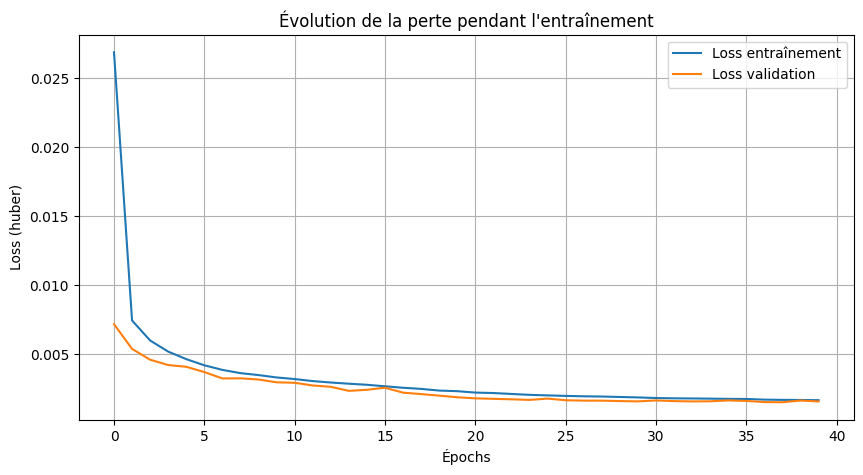

In [41]:

# Affichage de la loss d'entraînement et de validation
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss entraînement')
plt.plot(history.history['val_loss'], label='Loss validation')
plt.xlabel('Épochs')
plt.ylabel('Loss (huber)')
plt.title('Évolution de la perte pendant l\'entraînement')
plt.legend()
plt.grid(True)
plt.show()

240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


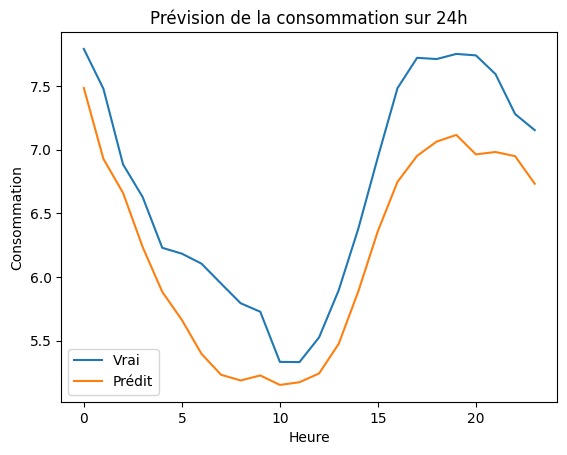

In [42]:


y_pred = model.predict(X_test)

#  inverser la normalisation
y_pred_inversed = scalers_minmax['Consommation'].inverse_transform(y_pred)
y_test_inversed = scalers_minmax['Consommation'].inverse_transform(y_test)

# Visualisation
plt.plot(y_test_inversed[0], label='Vrai')
plt.plot(y_pred_inversed[0], label='Prédit')
plt.legend()
plt.title("Prévision de la consommation sur 24h")
plt.xlabel("Heure")
plt.ylabel("Consommation")
plt.show()

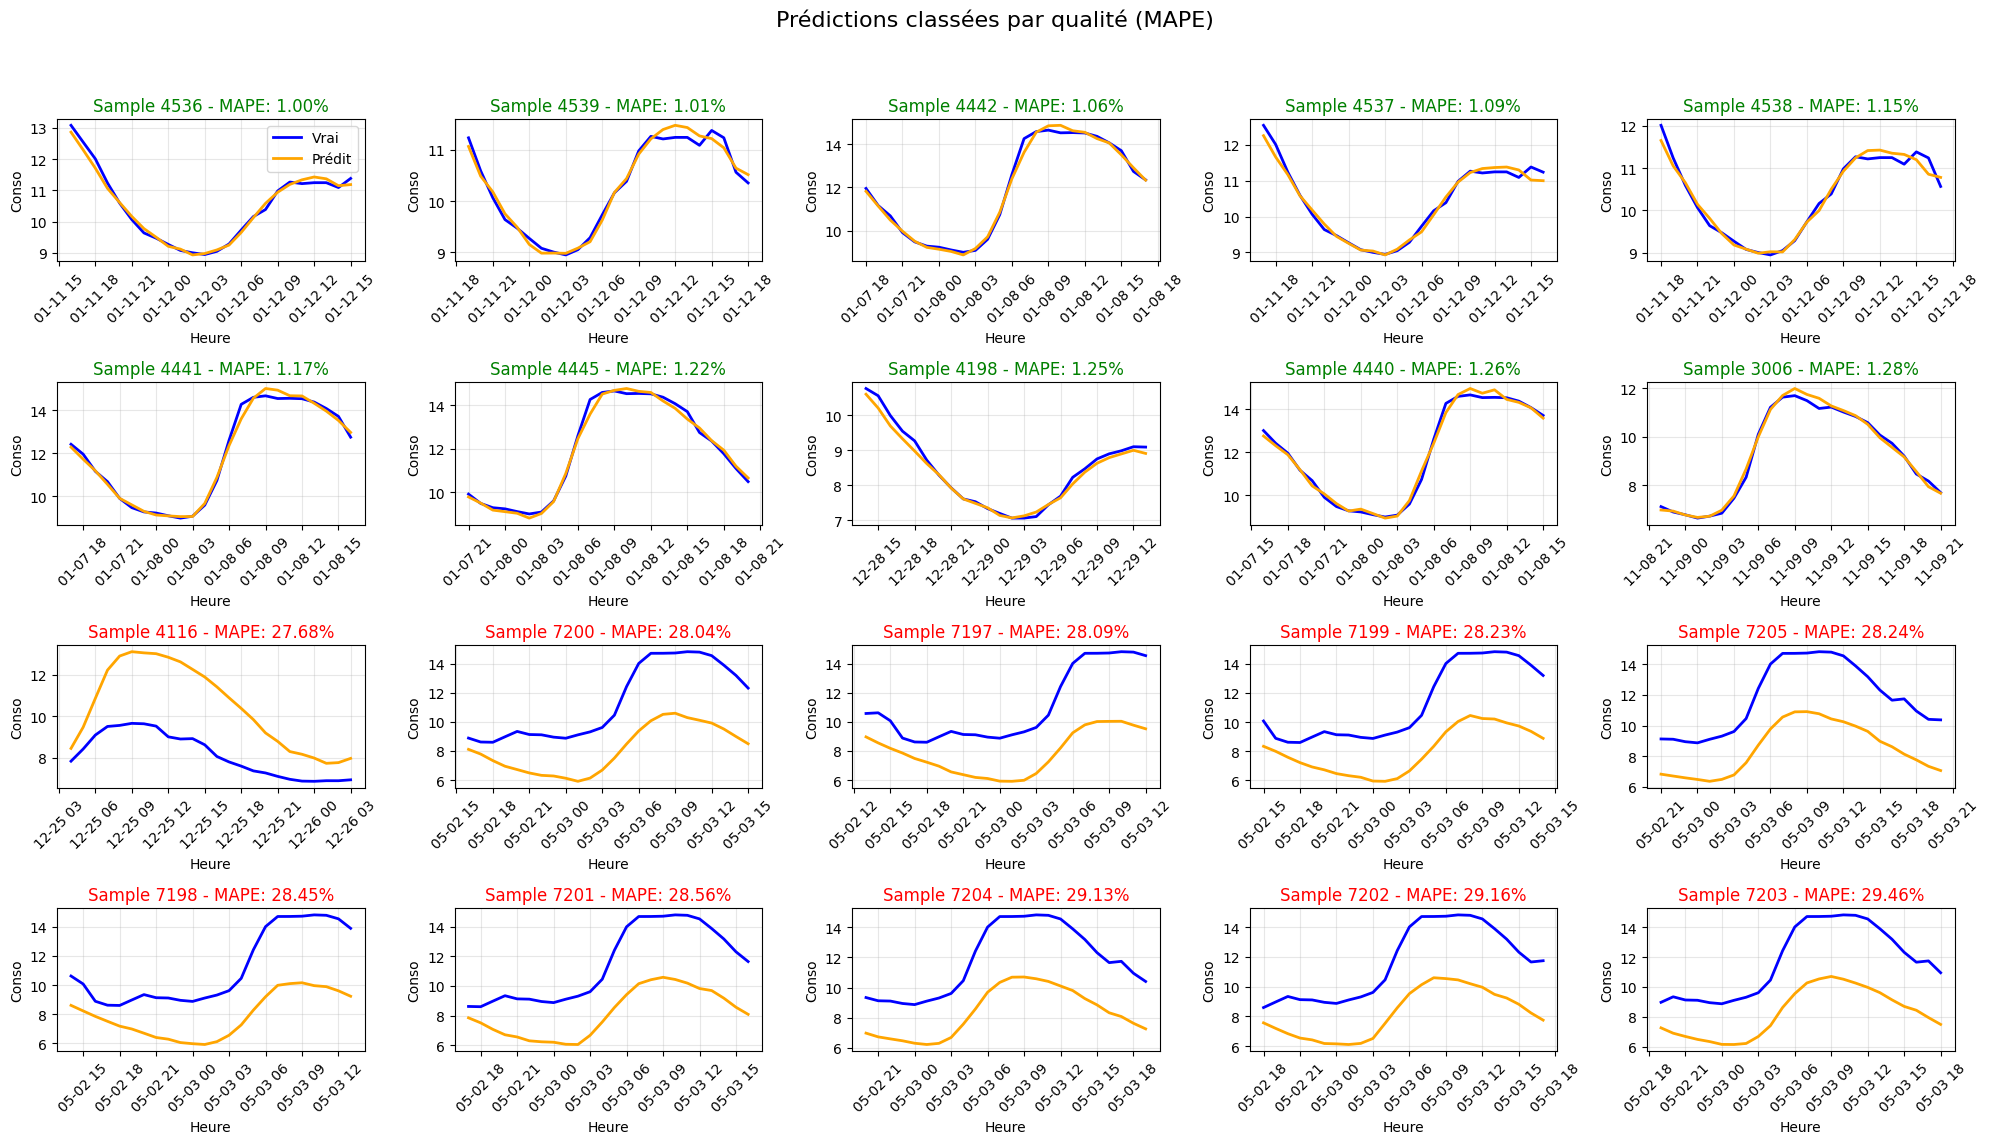

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np

def safe_mape(y_true, y_pred):
    """MAPE qui évite la division par zéro"""
    mask = y_true != 0
    if mask.sum() == 0:
        return 0
    return mean_absolute_percentage_error(y_true[mask], y_pred[mask]) * 100

# Vérifications
assert len(y_test_inversed) == len(y_pred_inversed)

# Calcul MAPE
mape_scores = [safe_mape(y_test_inversed[i], y_pred_inversed[i]) for i in range(len(y_test_inversed))]
sorted_indices = np.argsort(mape_scores)

# Sélection des échantillons
n_samples = min(10, len(y_test_inversed) // 2)
best_indices = sorted_indices[:n_samples]
worst_indices = sorted_indices[-n_samples:]
indices_to_plot = np.concatenate([best_indices, worst_indices])

# Timestamps
try:
    timestamps = df_normalise.index[sequence_length + forecast_horizon:]
    timestamps_test = timestamps[X_test_indices]
    use_timestamps = True
except:
    print("Utilisation d'indices simples pour les timestamps")
    use_timestamps = False

# Visualisation
n_plots = len(indices_to_plot)
n_cols = 5
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
fig.suptitle("Prédictions classées par qualité (MAPE)", fontsize=16)

# S'assurer que axes est un array 2D
if n_rows == 1:
    axes = axes.reshape(1, -1)

for i, idx in enumerate(indices_to_plot):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]
    
    # Axe X
    if use_timestamps:
        start_time = timestamps_test[idx]
        hours = [start_time + pd.Timedelta(hours=h) for h in range(forecast_horizon)]
        ax.plot(hours, y_test_inversed[idx], label='Vrai', color='blue', linewidth=2)
        ax.plot(hours, y_pred_inversed[idx], label='Prédit', color='orange', linewidth=2)
        ax.tick_params(axis='x', rotation=45)
    else:
        hours = range(forecast_horizon)
        ax.plot(hours, y_test_inversed[idx], label='Vrai', color='blue', linewidth=2)
        ax.plot(hours, y_pred_inversed[idx], label='Prédit', color='orange', linewidth=2)
    
    # Titres et labels
    color = 'green' if i < n_samples else 'red'  # Vert pour les meilleurs, rouge pour les pires
    ax.set_title(f"Sample {idx} - MAPE: {mape_scores[idx]:.2f}%", color=color)
    ax.set_xlabel("Heure")
    ax.set_ylabel("Conso")
    ax.grid(True, alpha=0.3)
    
    # Légende seulement sur le premier graphique
    if i == 0:
        ax.legend()

# Masquer les subplots vides
for i in range(n_plots, n_rows * n_cols):
    row, col = divmod(i, n_cols)
    axes[row, col].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

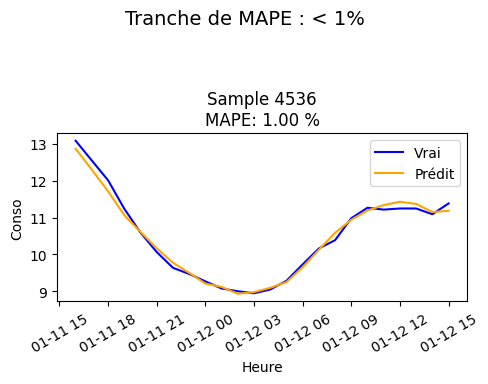

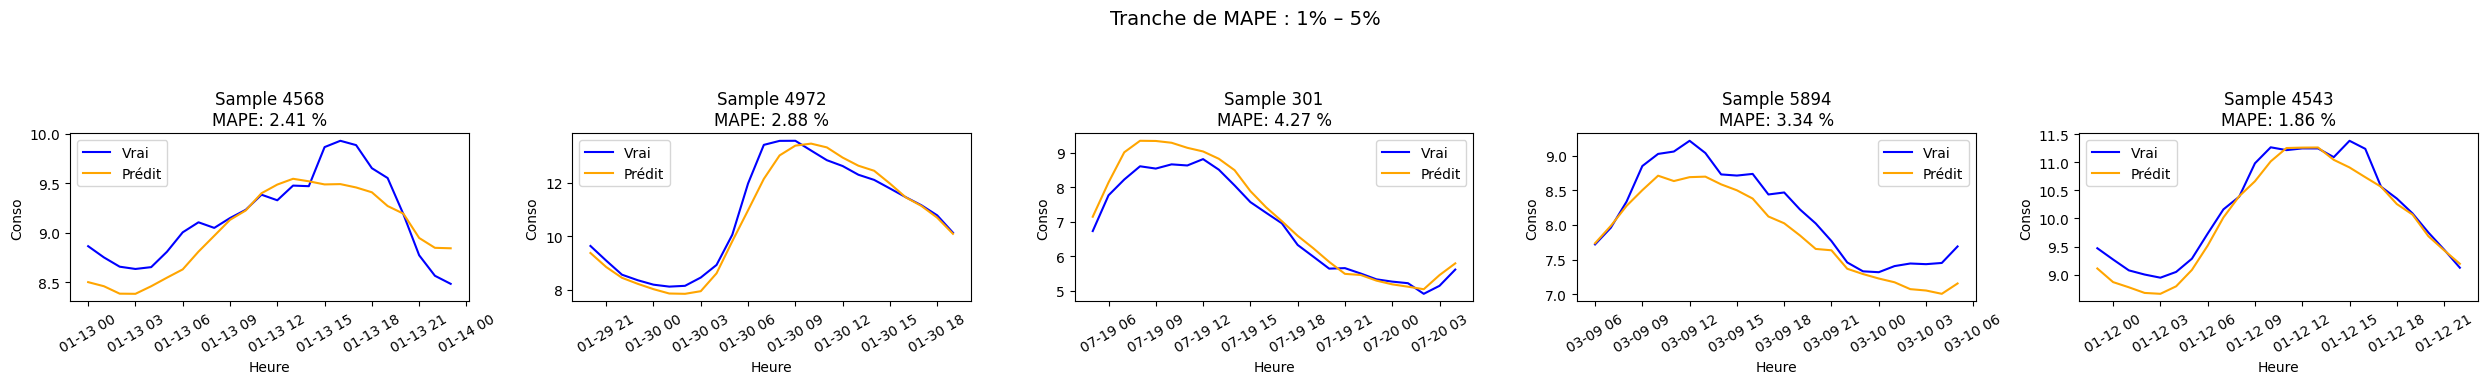

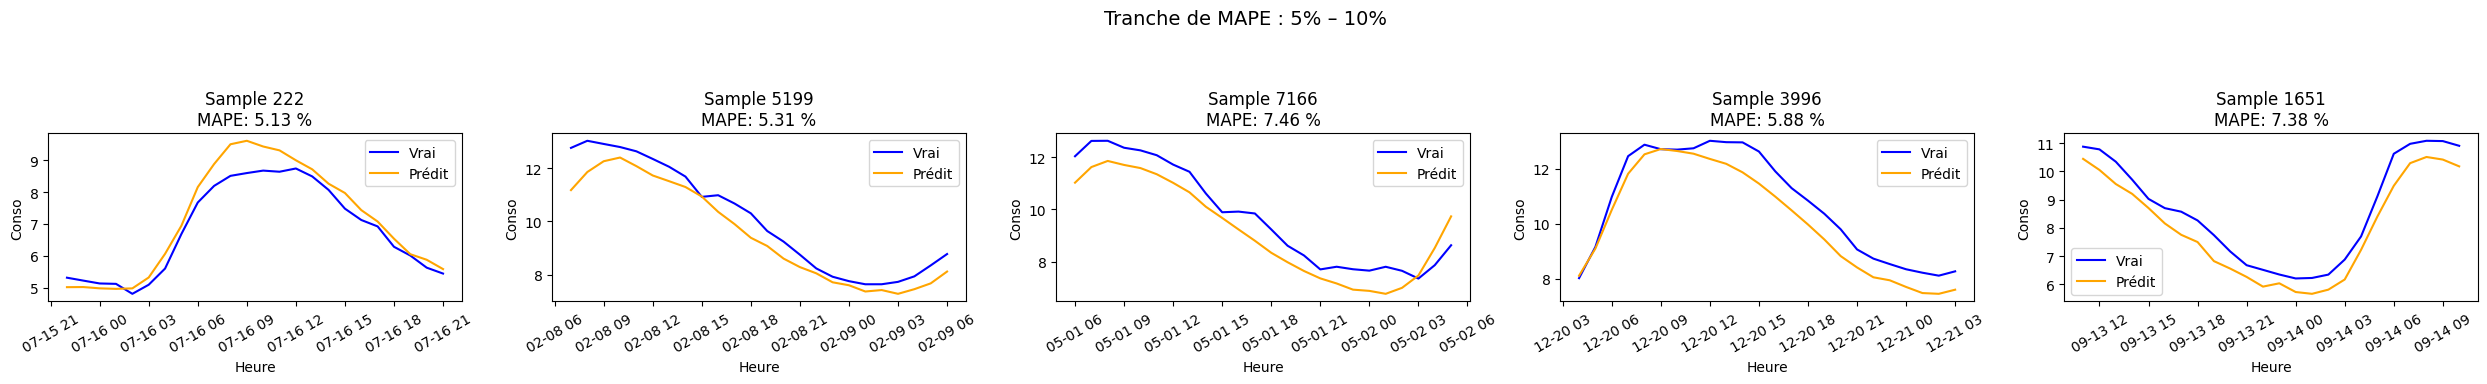

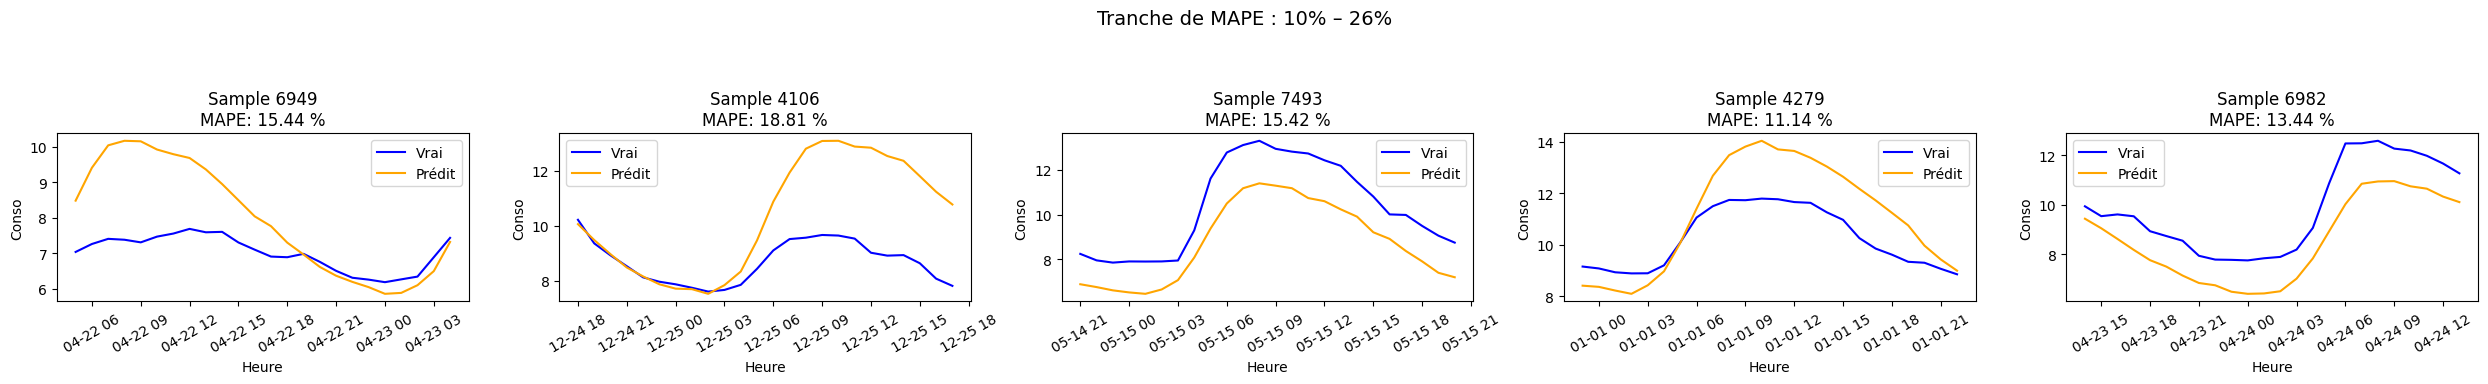

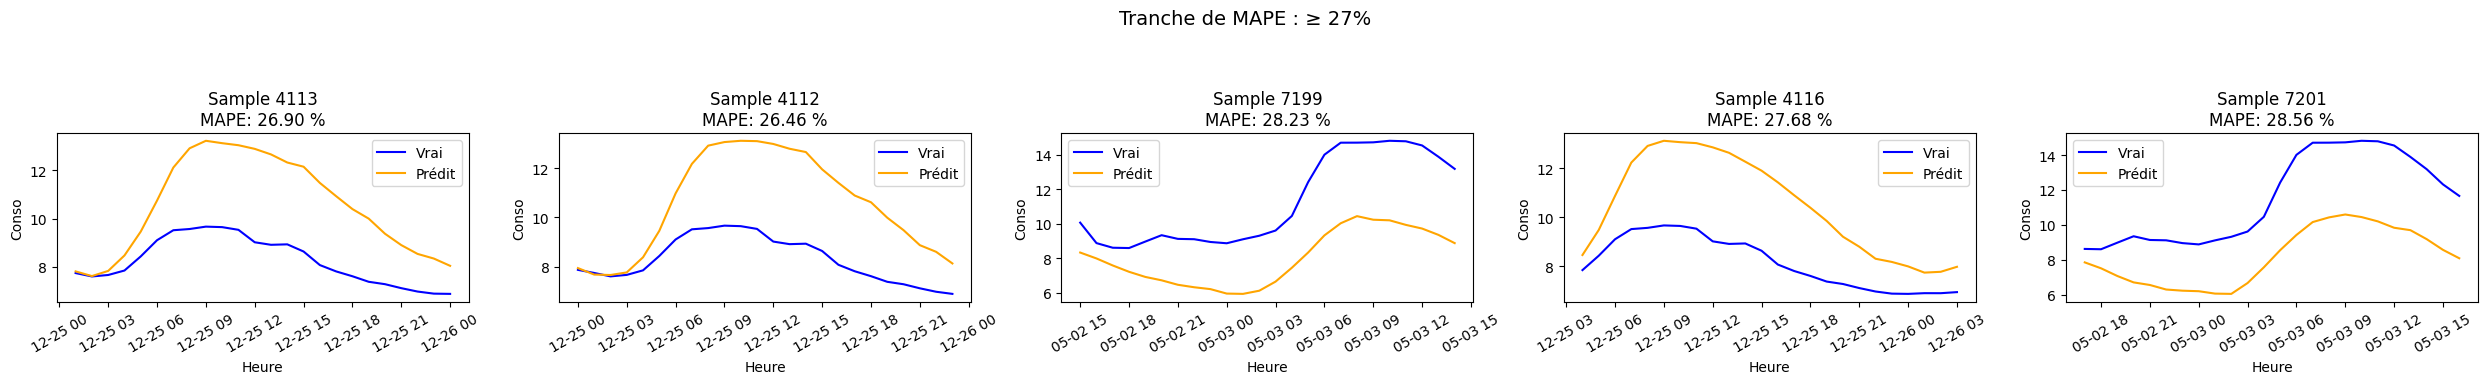

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np
import random
 
# Calcul des MAPE
mape_scores = [mean_absolute_percentage_error(y_test_inversed[i], y_pred_inversed[i]) * 100 for i in range(len(y_test_inversed))]
 
# Tranches de MAPE
mape_bins = {
    "< 1%": [],
    "1% – 5%": [],
    "5% – 10%": [],
    "10% – 26%": [],
    "≥ 27%": []
}
 
# Répartition des indices dans chaque tranche
for i, mape in enumerate(mape_scores):
    if mape < 1:
        mape_bins["< 1%"].append(i)
    elif mape < 5:
        mape_bins["1% – 5%"].append(i)
    elif mape < 10 :
        mape_bins["5% – 10%"].append(i)
    elif mape < 26 :
        mape_bins["10% – 26%"].append(i)
    else:
        mape_bins["≥ 27%"].append(i)
 
# Timestamps
try:
    timestamps = df_normalise.index[sequence_length + forecast_horizon:]
    timestamps_test = timestamps[X_test_indices]
    use_timestamps = True
except:
    print("Utilisation d'indices simples pour les timestamps")
    use_timestamps = False
 
# Affichage : 5 graphes par tranche
for category, indices in mape_bins.items():
    if len(indices) == 0:
        print(f"Aucun échantillon pour la tranche '{category}'")
        continue
 
    sample_indices = random.sample(indices, min(5, len(indices)))
 
    fig, axes = plt.subplots(1, len(sample_indices), figsize=(5 * len(sample_indices), 4))
    fig.suptitle(f"Tranche de MAPE : {category}", fontsize=14)
 
    # S'assurer que axes est itérable
    if len(sample_indices) == 1:
        axes = [axes]
 
    for ax, idx in zip(axes, sample_indices):
        start_time = timestamps_test[idx]
        hours = [start_time + pd.Timedelta(hours=h) for h in range(forecast_horizon)]
 
        ax.plot(hours, y_test_inversed[idx], label='Vrai', color='blue')
        ax.plot(hours, y_pred_inversed[idx], label='Prédit', color='orange')
        ax.set_title(f"Sample {idx}\nMAPE: {mape_scores[idx]:.2f} %")
        ax.set_xlabel("Heure")
        ax.set_ylabel("Conso")
        ax.xaxis.set_tick_params(rotation=30)
 
        ax.legend()
 
    plt.tight_layout(rect=[0, 0.03, 1, 0.90])
    plt.show()

In [ ]:

from sklearn.metrics import mean_absolute_percentage_error

test_mape = mean_absolute_percentage_error(y_test_inversed, y_pred_inversed) * 100   # Calcul du MAPE global sur l'ensemble du test
print(f"Test MAPE: {test_mape:.2f}%")




Test MAPE: 4.45%


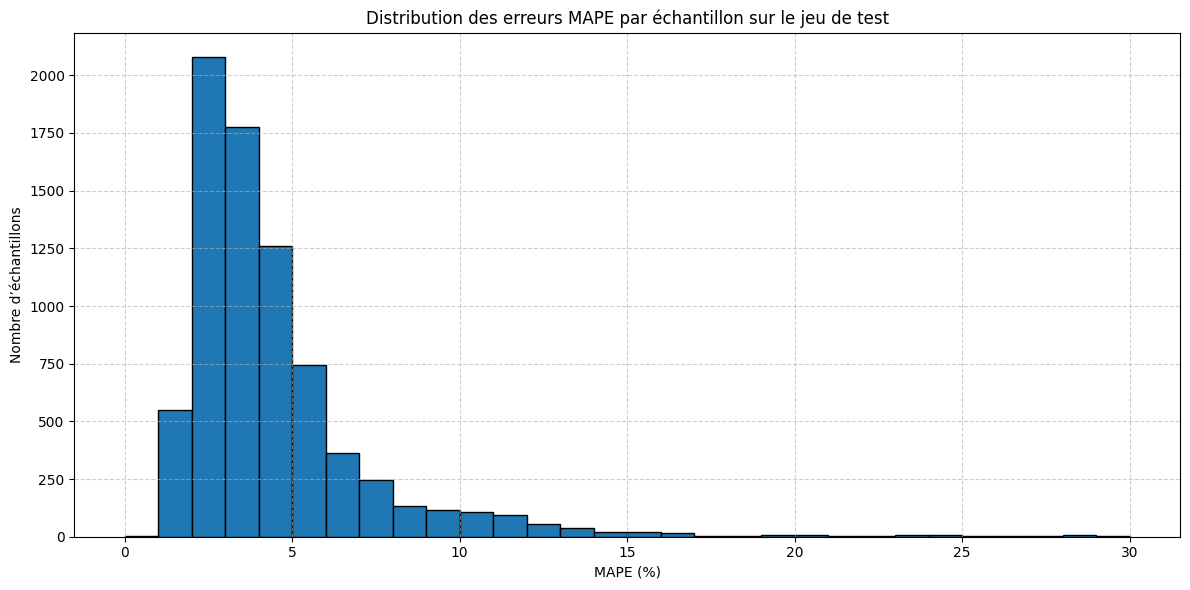

In [ ]:
import numpy as np
# Calcul du MAPE par échantillon
# Ici, on calcule le MAPE pour chaque échantillon et chaque horizon de prédiction
# puis on fait la moyenne sur l'horizon pour obtenir un score par échantillon
mape_per_sample = np.mean(np.abs((y_test_inversed - y_pred_inversed) / (y_test_inversed + 1e-8)) * 100, axis=1)   # Éviter la division par zéro en ajoutant un petit nombre (1e-8)

#  Regroupement des MAPE en intervalles (bins)
bins = np.arange(0, np.ceil(mape_per_sample.max()) + 1, 1)      # Créer des intervalles de 1% pour le MAPE

# Tracer l’histogramme
plt.figure(figsize=(12, 6))
plt.hist(mape_per_sample, bins=bins, edgecolor='black')
plt.xlabel("MAPE (%)")
plt.ylabel("Nombre d’échantillons")
plt.title("Distribution des erreurs MAPE par échantillon sur le jeu de test")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
dates_test = df_business_consumption.loc[X_test_indices, "Date"]  # Obtenir les dates correspondantes aux indices de test

C:\Users\emac\AppData\Local\Temp\ipykernel_24180\203230114.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby("MAPE_bin").size()


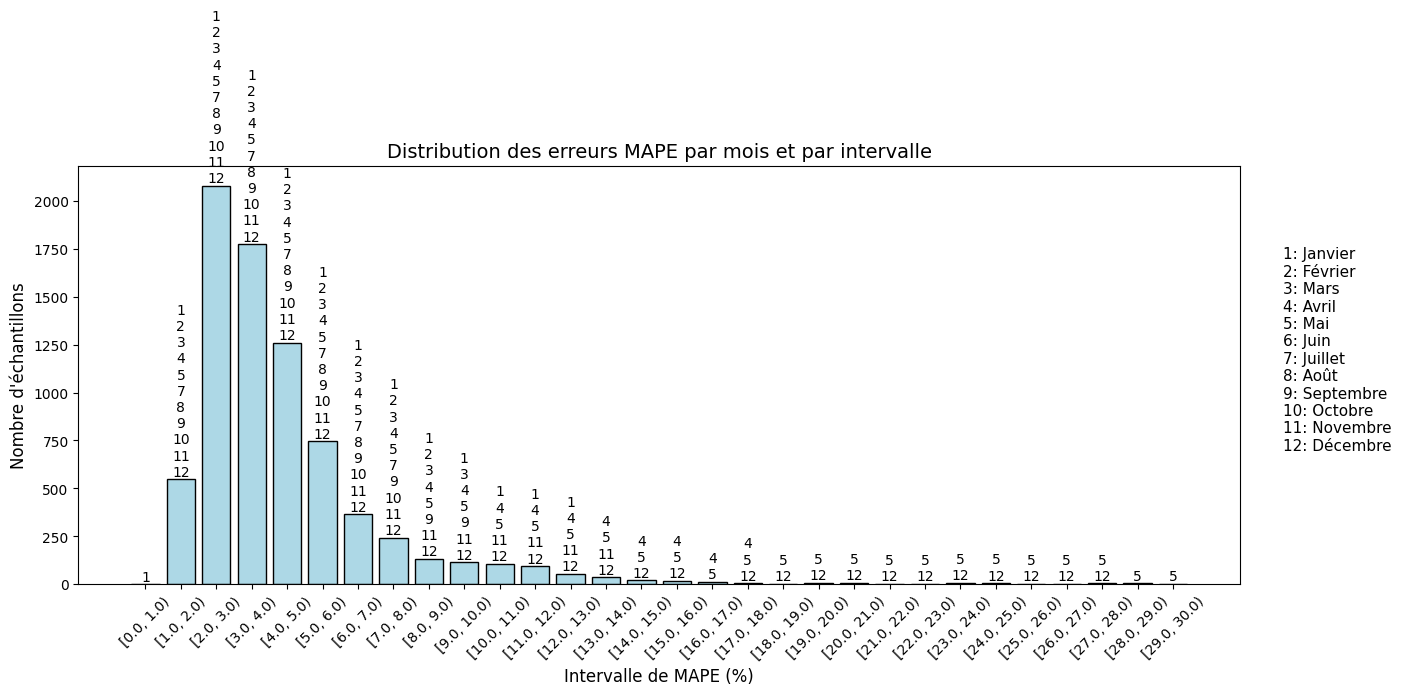

In [ ]:
# Convertir timestamps en datetime si ce n'est pas déjà fait
timestamps_test = pd.to_datetime(timestamps_test)

# Pour chaque timestamp, extraire tous les mois couverts par l'horizon de 24h
mois_par_sample = []
for t in timestamps_test:
    # Générer la série horaire pour l'horizon
    dates_horizon = pd.date_range(start=t, periods=forecast_horizon, freq='h')
    # Extraire les mois uniques
    mois = dates_horizon.month.unique()
    mois_par_sample.append(mois)

#  Créer les intervalles de MAPE (par exemple 1%)
bins = np.arange(0, np.ceil(mape_per_sample.max()) + 1, 1)

# Construire DataFrame
df = pd.DataFrame({
    "MAPE": mape_per_sample,
    "Mois": mois_par_sample
})
df["MAPE_bin"] = pd.cut(df["MAPE"], bins=bins, right=False)

# Grouper par bin pour compter les échantillons
df_grouped = df.groupby("MAPE_bin").size()

#  Plot
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(df_grouped.index.astype(str), df_grouped.values, edgecolor='black', color='lightblue')

#  Ajouter tous les mois (aplatir les listes) au-dessus des barres
for i, bin_label in enumerate(df_grouped.index):
    mois_listes = df.loc[df["MAPE_bin"] == bin_label, "Mois"]
    # Aplatir les listes et extraire les mois uniques
    tous_les_mois = sorted(set(m for sous_liste in mois_listes for m in sous_liste))
    mois_str = "\n".join(str(m) for m in tous_les_mois)
    ax.text(i, df_grouped.values[i] + 1, mois_str, ha='center', va='bottom', fontsize=10, color='black')

#  Mise en forme
ax.set_title("Distribution des erreurs MAPE par mois et par intervalle", fontsize=14)
ax.set_xlabel("Intervalle de MAPE (%)", fontsize=12)
ax.set_ylabel("Nombre d'échantillons", fontsize=12)
plt.xticks(rotation=45)

# Légende mois à droite
mois_legende = "\n".join([
    "1: Janvier", "2: Février", "3: Mars", "4: Avril",
    "5: Mai", "6: Juin", "7: Juillet", "8: Août",
    "9: Septembre", "10: Octobre", "11: Novembre", "12: Décembre"
])
plt.gcf().text(0.92, 0.5, mois_legende, fontsize=11, va='center')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

C:\Users\emac\AppData\Local\Temp\ipykernel_24180\581572370.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby("MAPE_bin").size()


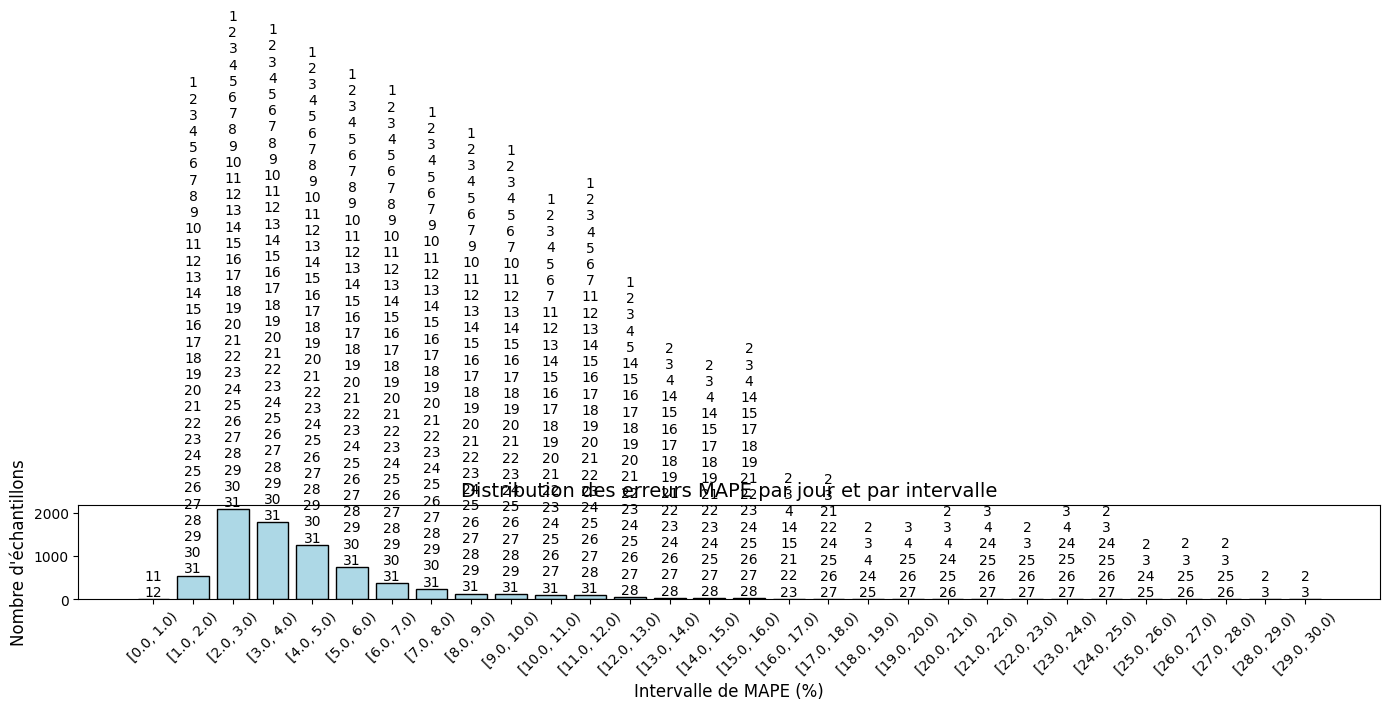

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



timestamps_test = pd.to_datetime(timestamps_test)

# Extraire tous les jours (numéro du jour dans le mois) couverts par chaque horizon
jours_par_sample = []
for t in timestamps_test:
    dates_horizon = pd.date_range(start=t, periods=forecast_horizon, freq='h')
    jours = dates_horizon.day.unique()  # jours dans le mois
    jours_par_sample.append(jours)

# Intervalles de MAPE (ajuste selon ton max MAPE)
bins = np.arange(0, np.ceil(mape_per_sample.max()) + 1, 1)

# DataFrame avec MAPE et jours multiples
df = pd.DataFrame({
    "MAPE": mape_per_sample,
    "Jours": jours_par_sample
})
df["MAPE_bin"] = pd.cut(df["MAPE"], bins=bins, right=False)

# Compter les échantillons par intervalle
df_grouped = df.groupby("MAPE_bin").size()

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(df_grouped.index.astype(str), df_grouped.values, edgecolor='black', color='lightblue')

# Ajouter les jours uniques au-dessus des barres
for i, bin_label in enumerate(df_grouped.index):
    jours_listes = df.loc[df["MAPE_bin"] == bin_label, "Jours"]
    tous_les_jours = sorted(set(j for sous_liste in jours_listes for j in sous_liste))
    jours_str = "\n".join(str(j) for j in tous_les_jours)
    ax.text(i, df_grouped.values[i] + 1, jours_str, ha='center', va='bottom', fontsize=10, color='black')

# Mise en forme
ax.set_title("Distribution des erreurs MAPE par jour et par intervalle", fontsize=14)
ax.set_xlabel("Intervalle de MAPE (%)", fontsize=12)
ax.set_ylabel("Nombre d'échantillons", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


C:\Users\emac\AppData\Local\Temp\ipykernel_24180\1508907743.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby("MAPE_bin").size()


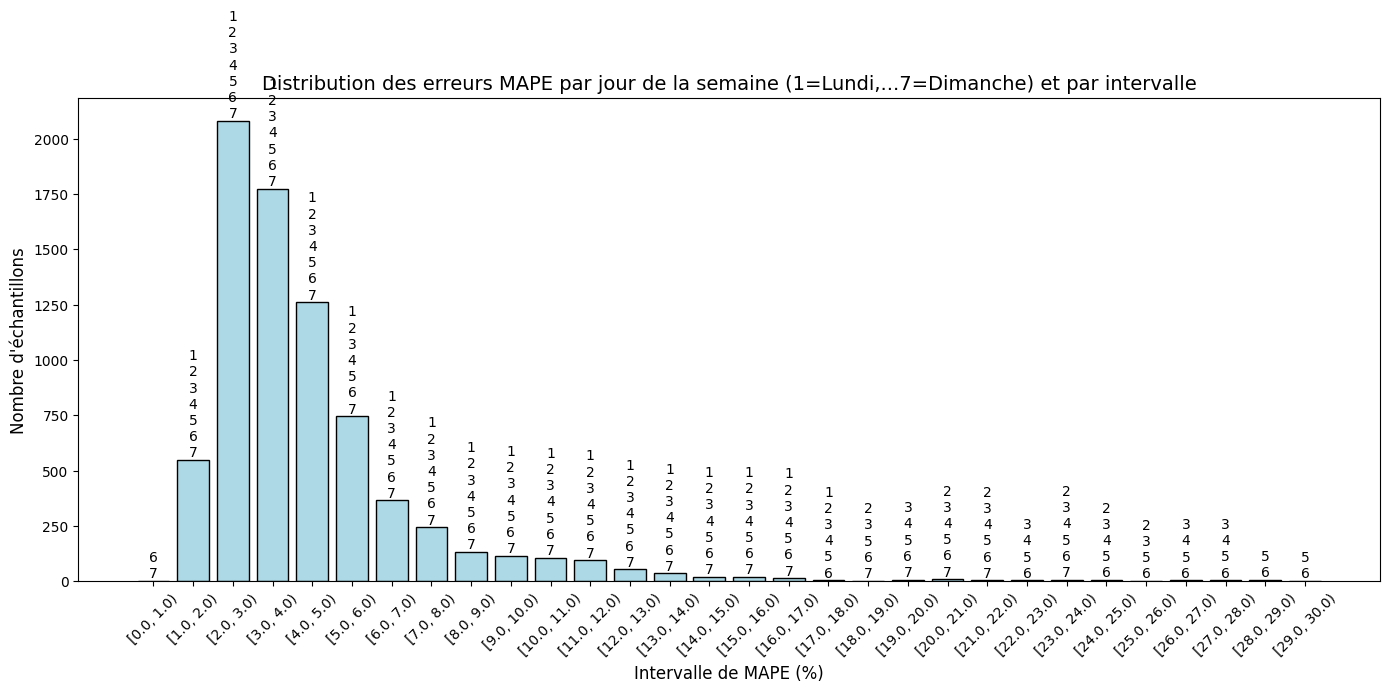

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



timestamps_test = pd.to_datetime(timestamps_test)

# Extraire les jours de la semaine couverts par chaque horizon (1=Lundi ... 7=Dimanche)
jours_sem_par_sample = []
for t in timestamps_test:
    dates_horizon = pd.date_range(start=t, periods=forecast_horizon, freq='h')
    jours_idx = dates_horizon.dayofweek.unique()  # 0=Lundi ... 6=Dimanche
    # Convertir en 1-7
    jours_chiffres = [j + 1 for j in jours_idx]
    jours_sem_par_sample.append(jours_chiffres)

# Intervalles de MAPE
bins = np.arange(0, np.ceil(mape_per_sample.max()) + 1, 1)

# DataFrame avec MAPE et jours de la semaine multiples
df = pd.DataFrame({
    "MAPE": mape_per_sample,
    "Jours_semaine": jours_sem_par_sample
})
df["MAPE_bin"] = pd.cut(df["MAPE"], bins=bins, right=False)

# Compter les échantillons par intervalle
df_grouped = df.groupby("MAPE_bin").size()

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(df_grouped.index.astype(str), df_grouped.values, edgecolor='black', color='lightblue')

# Ajouter les jours de la semaine uniques (chiffres) au-dessus des barres
for i, bin_label in enumerate(df_grouped.index):
    jours_listes = df.loc[df["MAPE_bin"] == bin_label, "Jours_semaine"]
    tous_les_jours = sorted(set(j for sous_liste in jours_listes for j in sous_liste))
    jours_str = "\n".join(str(j) for j in tous_les_jours)
    ax.text(i, df_grouped.values[i] + 1, jours_str, ha='center', va='bottom', fontsize=10, color='black')

# Mise en forme
ax.set_title("Distribution des erreurs MAPE par jour de la semaine (1=Lundi,...7=Dimanche) et par intervalle", fontsize=14)
ax.set_xlabel("Intervalle de MAPE (%)", fontsize=12)
ax.set_ylabel("Nombre d'échantillons", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

## Variation d'horizon de temps 

 répondre à une question :

 Comment la performance de mon modèle LSTM se dégrade-t-elle lorsque j’essaie de prédire de plus en plus loin dans le futur (augmentation de l’horizon de prédiction) ?

In [ ]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' # Désactiver les optimisations OneDNN de TensorFlow
import json      # Importer json pour sauvegarder l'historique
import tensorflow as tf   # Importer TensorFlow
from tensorflow.keras.models import Sequential         # Importer les modules nécessaires
from tensorflow.keras.layers import LSTM, Dense        # Importer les couches LSTM et Dense
from tensorflow.keras.optimizers import Adam          # Importer l'optimiseur Adam qui est utilisé pour l'entraînement pour optimiser la fonction de perte 
from tensorflow.keras import backend as K            # Importer les fonctions backend de Keras pour la gestion de la mémoire
from tensorflow.keras.metrics import MeanAbsolutePercentageError        # Importer la métrique MAPE pour évaluer la performance du modèle
from sklearn.metrics import mean_squared_error, mean_absolute_error        # Importer les métriques de performance pour évaluer le modèle
import gc   # Importer le module gc pour la gestion de la mémoire

# Paramètres fixes
sequence_length = 48      # Longueur de la séquence d'entrée
learning_rate = 0.0001     # Taux d'apprentissage pour l'optimiseur Adam 
batch_size = 30           # Taille du batch pour l'entraînement
epochs = 40       # Nombre d'époques pour l'entraînement
target_col = "Consommation"     # Colonne cible pour la prédiction

# Fonction pour créer les séquences
def create_sequences(data, target_col, sequence_length, forecast_horizon):          # Fonction pour créer les séquences
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon):    # Boucle pour créer les séquences
        X.append(data.iloc[i:i+sequence_length].values)         # Séquence d'entrée
        y.append(data.iloc[i+sequence_length:i+sequence_length+forecast_horizon][target_col].values)     # Séquence cible
    return np.array(X), np.array(y)   

# Générer les horizons avec pas variable
forecast_horizons = list(range(1, 110)) \
                 + list(range(110, 301, 10)) \
                 + list(range(300, 2001, 100))          # Liste des horizons de prévision à tester

# Chargement des résultats sauvegardés
results_file = 'results_horizon.csv'    # Fichier pour stocker les résultats des prévisions
print("Chargement du fichier :", results_file)
if os.path.exists(results_file):          # Vérifier si le fichier existe
    results_df = pd.read_csv(results_file)    # Charger les résultats précédents
    processed_horizons = set(results_df['horizon'].values)    # Extraire les horizons déjà traités
    print("Nombre d'horizons déjà traités :", len(processed_horizons))     # Si le fichier existe, on charge les résultats précédents
else:       # Si le fichier n'existe pas, on initialise un DataFrame vide
    processed_horizons = set()      # Initialiser un ensemble vide pour les horizons traités
    results_df = pd.DataFrame(columns=["horizon", "MAE", "RMSE", "MAPE"])      # Initialiser un DataFrame vide pour stocker les résultats

# Boucle principale
for horizon in forecast_horizons:      # Pour chaque horizon de prévision
    if horizon in processed_horizons:     # Si l'horizon a déjà été traité, on passe au suivant
        print(f"Horizon {horizon} déjà traité, passage au suivant.")       # Si l'horizon a déjà été traité, on passe au suivant
        continue   # Si l'horizon a déjà été traité, on passe au suivant
    
    print(f"Training for forecast_horizon = {horizon}...")       # Afficher l'horizon de prévision en cours de traitement

    # Création des données
    X, y = create_sequences(df_normalise, target_col, sequence_length, horizon)     # Créer les séquences d'entrée et de sortie pour l'horizon de prévision actuel
    split_idx = int(0.8 * len(X))         # Indice de séparation pour l'entraînement et le test
    X_train, X_test = X[:split_idx], X[split_idx:]   # Séparer les données en ensembles d'entraînement et de test
    y_train, y_test = y[:split_idx], y[split_idx:]    # Séparer les cibles en ensembles d'entraînement et de test

    # Modèle LSTM 
    model = Sequential([
        LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, input_shape=(sequence_length, X.shape[2])), # Première couche LSTM
        LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=False),       # Deuxième couche LSTM
        Dense(horizon, activation='linear')   # Couche de sortie pour prédire l'horizon de prévision
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=[MeanAbsolutePercentageError()])    # Compiler le modèle avec l'optimiseur Adam et la métrique MAPE

    # Entraînement
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=0
    )

    # Prédiction
    y_pred = model.predict(X_test)   # Faire des prédictions sur l'ensemble de test

    # Dénormalisation
    scaler = scalers_minmax["Consommation"] # Récupérer le scaler pour la dénormalisation que nous avons utilisé MinMaxScaler pour normaliser les données
    y_test_denorm = scaler.inverse_transform(y_test.reshape(-1, 1))       # Dénormaliser les valeurs réelles nous avons utilisé reshape pour s'assurer que y_test a la bonne forme pour la dénormalisation
    y_pred_denorm = scaler.inverse_transform(y_pred.reshape(-1, 1))     # Dénormaliser les valeurs prédites

    # Calcul des métriques
    mae = mean_absolute_error(y_test_denorm, y_pred_denorm)      #calculer l'erreur absolue moyenne (MAE) 
    rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))   #calculer la racine carrée de l'erreur quadratique moyenne (RMSE)
    mape = np.mean(np.abs((y_test_denorm - y_pred_denorm) / (y_test_denorm + 1e-8))) * 100    # calculer l'erreur absolue moyenne en pourcentage (MAPE) en évitant la division par zéro on ajoute une petite constante (1e-8)
    # Sauvegarde du modèle
    model_path = f"models/model_h{horizon}.keras"     # Chemin pour sauvegarder le modèle
    model.save(model_path)

    # Sauvegarde de l’historique
    history_path = f"models/history_h{horizon}.json"    # Chemin pour sauvegarder l'historique de l'entraînement
    with open(history_path, 'w') as f:
       json.dump(history.history, f)
       
    # Sauvegarde du résultat
    new_row = pd.DataFrame([{
    "horizon": horizon,
    "MAE": mae,
    "RMSE": rmse,
    "MAPE": mape
    }])

    results_df = pd.concat([results_df, new_row], ignore_index=True)


    results_df.to_csv(results_file, index=False)

    # Libération mémoire
    K.clear_session()
    del model, X, y, X_train, X_test, y_train, y_test, y_pred, y_test_denorm, y_pred_denorm
    gc.collect()


Chargement du fichier : results_horizon.csv
Nombre d'horizons déjà traités : 140
Horizon 1 déjà traité, passage au suivant.
Horizon 2 déjà traité, passage au suivant.
Horizon 3 déjà traité, passage au suivant.
Horizon 4 déjà traité, passage au suivant.
Horizon 5 déjà traité, passage au suivant.
Horizon 6 déjà traité, passage au suivant.
Horizon 7 déjà traité, passage au suivant.
Horizon 8 déjà traité, passage au suivant.
Horizon 9 déjà traité, passage au suivant.
Horizon 10 déjà traité, passage au suivant.
Horizon 11 déjà traité, passage au suivant.
Horizon 12 déjà traité, passage au suivant.
Horizon 13 déjà traité, passage au suivant.
Horizon 14 déjà traité, passage au suivant.
Horizon 15 déjà traité, passage au suivant.
Horizon 16 déjà traité, passage au suivant.
Horizon 17 déjà traité, passage au suivant.
Horizon 18 déjà traité, passage au suivant.
Horizon 19 déjà traité, passage au suivant.
Horizon 20 déjà traité, passage au suivant.
Horizon 21 déjà traité, passage au suivant.
Hori

c:\Users\omghyly\Downloads\Nouveau dossier\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step

Training for forecast_horizon = 1600...


c:\Users\omghyly\Downloads\Nouveau dossier\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Training for forecast_horizon = 1700...


c:\Users\omghyly\Downloads\Nouveau dossier\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Training for forecast_horizon = 1800...


c:\Users\omghyly\Downloads\Nouveau dossier\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Training for forecast_horizon = 1900...


c:\Users\omghyly\Downloads\Nouveau dossier\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Training for forecast_horizon = 2000...


c:\Users\omghyly\Downloads\Nouveau dossier\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
